# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from Agent.ddpg_agent import Agent
from Agent.ddpg_agent_homogeneous import Agent_H
import random, torch, time
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from torch.autograd import Variable

%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='C:/Users/u224870/Projekte/Reacher2/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 4.My solution
When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

Heterogeneous agents: This means each agent has its own policy and acts accordingly. The agents only share their experiences

In [5]:
#agent = Agent(state_size=33, action_size=4,nbr_agents = num_agents, random_seed=2)

Alternatively we can use homogeneous agents which all share the same policy. This method trains much faster as only one neural net needs to be updated. However we only expolre with one single agent over 20 parallel trajectories.

In [6]:
agent = Agent_H(state_size=33, action_size=4,nbr_agents = num_agents, random_seed=2)

In [7]:
n_episodes=1000
print_every=100
scores_deque = deque(maxlen=print_every)
scores = np.zeros(num_agents)     

In [8]:
def ddpg(n_episodes=1000, max_t=1000):
        
    scores_window = deque(maxlen=100)
    scores = []
    total_time_elapsed = 0
    for i_episode in range(1, n_episodes+1):
        avg_score = 0
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores_t = np.zeros(num_agents)                        # initialize the score (for each agent)
        agent.reset()
        score = 0
        for t_step in range(max_t):
            actions = agent.act(states)     
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished   
            agent.step(states, actions, rewards, next_states, dones, t_step)
            states = next_states
            scores_t += rewards
            if np.any(dones):
                break
        
        score = np.mean(scores_t)
        scores_window.append(score)
        avg_score = np.mean(scores_window)
        scores.append(score)        
        

        print("\rEpisode {:}\t Average Score {:.2f}\tMax Score {:.2f}".format(i_episode, avg_score, scores_t.max()), end="")

        
        if i_episode % 100 == 0:
            print("\rEpisode {:}\t Average Score {:.2f}\tMax Score {:.2f}".format(i_episode, avg_score, scores_t.max()))

        if avg_score >= 30:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, avg_score))
            torch.save(agent.actor_local.state_dict(), './Nets/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), './Nets/checkpoint_critic.pth')
            
        if avg_score >= 35:
            torch.save(agent.actor_local.state_dict(), './Nets/checkpoint_actor_best.pth')
            torch.save(agent.critic_local.state_dict(), './Nets/checkpoint_critic_best.pth') 
            break
    return scores

array([38.08999915, 30.15999933, 38.18999915, 37.05999917, 38.05999915,
       37.53999916, 34.73999922, 35.9099992 , 38.34999914, 39.65999911,
       34.91999922, 35.7599992 , 37.52999916, 39.07999913, 39.39999912,
       38.22999915, 32.83999927, 37.71999916, 37.24999917, 34.64999923])

Episode 100	 Average Score 12.20	Max Score 35.40
Episode 177	 Average Score 30.09	Max Score 38.90
Environment solved in 177 episodes!	Average Score: 30.09
Episode 178	 Average Score 30.26	Max Score 38.77
Environment solved in 178 episodes!	Average Score: 30.26
Episode 179	 Average Score 30.42	Max Score 38.65
Environment solved in 179 episodes!	Average Score: 30.42
Episode 180	 Average Score 30.58	Max Score 39.01
Environment solved in 180 episodes!	Average Score: 30.58
Episode 181	 Average Score 30.73	Max Score 38.64
Environment solved in 181 episodes!	Average Score: 30.73
Episode 182	 Average Score 30.90	Max Score 38.97
Environment solved in 182 episodes!	Average Score: 30.90
Episode 183	 Average Score 31.06	Max Score 38.63
Environment solved in 183 episodes!	Average Score: 31.06
Episode 184	 Average Score 31.23	Max Score 38.45
Environment solved in 184 episodes!	Average Score: 31.23
Episode 185	 Average Score 31.39	Max Score 38.11
Environment solved in 185 episodes!	Average Score: 31.

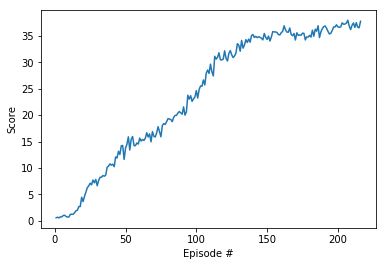

In [9]:
# Train agents
scores = ddpg()

#Plot results
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [24]:
scores_window = deque(maxlen=100)
scores_avg = []
for i in range(len(scores)):
    scores_window.append(scores[i])
    scores_avg.append(np.mean(scores_window))

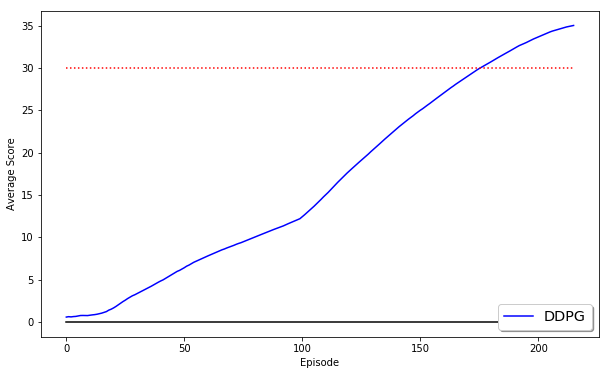

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(scores_avg,color ='b',  label='DDPG')
ax.plot(np.zeros(len(scores_avg)),'black')
ax.plot(30*np.ones(len(scores_avg)),'r:')
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.xlabel("Episode")
plt.ylabel("Average Score")
fig.savefig("./Images/Training.png")

In [10]:
env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores_t = np.zeros(num_agents)                        # initialize the score (for each agent)
agent.reset()
score = 0
t_step = 0
agent.load('./Nets/checkpoint_actor_best.pth','./Nets/checkpoint_critic_best.pth')
while True:
    actions = agent.act(states)     
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished   
    states = next_states
    scores_t += rewards
    if np.any(dones):
        break
print(np.mean(scores_t))

36.756999178417026


In [11]:
env.close()